<a href="https://colab.research.google.com/github/blackdragonae/h0wsh2021/blob/main/HubbleConstant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Constantante de Hubble** 
---



Sincronizando el Drive de google 

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalando la librerias de python para hacer los calculos:

In [2]:
!pip install zeus-mcmc
!pip install getdist

     |████████████████████████████████| 28.5 MB 54 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 776 kB 7.0 MB/s 
     |████████████████████████████████| 636 kB 39.8 MB/s 
  Created wheel for getdist: filename=GetDist-1.3.1-py3-none-any.whl size=226243 sha256=ffb825c71f44bb2acac3f6abb53a6c70b9f9acb559093942737c121ae79d92e5
  Stored in directory: /root/.cache/pip/wheels/94/e9/59/d542a0fca96a0ffc98a155095f0e70eb31cde1a6a4a25e6495
Successfully built getdist
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Succ

Importando las librerias necesarias para los calculos

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import os
from astropy.table import Table
from astropy.cosmology import FlatwCDM
from getdist import plots, MCSamples
import zeus
from zeus import ChainManager
import numpy as np
import scipy.optimize as op
from multiprocessing import Pool

Función Log Likelihood 

In [4]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    alpha, beta, h0 = theta

    Or = 4.153e-5 * h0**(-2)
    Om = 0.3
    w0 = -1.0

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

Definición de los priors

In [5]:
def lnprior(theta):
    alpha, beta, h0 = theta
    if (0.0 <= beta <= 10.0 and 20.0 <= alpha <= 40.0 and 0.5 <= h0 <= 1.0):
        return 0.0
    return -np.inf

Función de Log Posterior

In [6]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

Función de lectura de datos

In [7]:
def h2gdat(dpath):
    LSL = 1.83  # 1.84
    Tpath = dpath+'indat/Union2020v16.dat'
    data = Table.read(Tpath, format='ascii', comment='#')

    vix = data['col1']

    vx = data['col2']
    vy = data['col3']
    vz = data['col4']

    vxErr = data['col5']
    vyErr = data['col6']
    vzErr = data['col7']

    vsp = data['col8']

    rXY = np.corrcoef(vx, vy)
    vRxy = vx*0.0 + rXY[0,1]

    ix = np.where((vx - vxErr) <= LSL)
    # ix = np.where((vx + vxErr) <= LSL)
    # ix = np.where((vx - vxErr) <= 1.8)

    return (vix[ix], vx[ix], vy[ix], vz[ix], vxErr[ix], vyErr[ix], vzErr[ix],
            vRxy[ix], vsp[ix])

Inicio del codigo principal, definición del directorio de datos

In [8]:
# Main Code
dpath = '/content/drive/MyDrive/h0wsh2021/dat/'
print('Data path:', dpath)

Data path: /content/drive/MyDrive/h0wsh2021/dat/


Leyendo los datos

In [9]:
# Reading Data
vTg, vx, vy, vz, vxErr, vyErr, vzErr, vRxy, vsp = h2gdat(dpath)

Aproximación inicial para el resultado

In [10]:
# First guess
parameters = [r"\alpha", r"\beta", r"h_0"]
ialpha = 32.0
ibeta = 5.0
ih0 = 0.75

Cálculo de maximización de probablilidad

In [11]:
# Maximum Likelihood
nll = lambda *args: -lnlike(*args)[0]
result = op.minimize(nll, [ialpha, ibeta, ih0],
                args=(vx, vy, vz, vxErr, vyErr, vzErr)
            )
alpha_ml, beta_ml, h0_ml = result["x"]

print('max llq results:')
print('alpha = ', alpha_ml)
print('beta = ', beta_ml)
print('h0 = ', h0_ml)

max llq results:
alpha =  33.21697137329048
beta =  5.0460068435276355
h0 =  0.7156988175065973


Cálculo de MCMC

In [12]:
# MCMC
nsteps = 1000
ndim, nwalkers = 3, 10
start = [[alpha_ml, beta_ml, h0_ml] + 1e-5*np.random.randn(ndim)
       for i in range(nwalkers)]

with Pool() as pool:
  sampler = zeus.EnsembleSampler(nwalkers, ndim, lnpost, 
                                 args=(vx, vy, vz, vxErr, vyErr, vzErr), pool=pool)
  sampler.run_mcmc(start, nsteps)

sampler.summary

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 3
Number of Walkers: 10
Number of Tuning Generations: 20
Scale Factor: 0.633712
Mean Integrated Autocorrelation Time: 6.06
Effective Sample Size: 1650.37
Number of Log Probability Evaluations: 60690
Effective Samples per Log Probability Evaluation: 0.027194


Visulización de la cadena calculada 

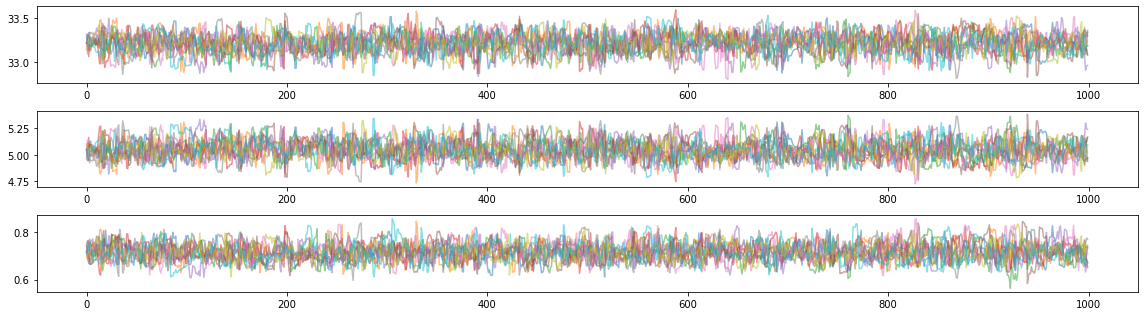

In [13]:
path = dpath+'results/chain_test.pdf'
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
plt.tight_layout()
plt.savefig(path)
plt.show()


Eliminando burn-in y aplanando las cadenas

In [15]:
# flatten the chains, thin them by a factor of 1, and remove the burn-in (first 25% of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//4, thin=1)

Graficando resultados

Removed no burn in


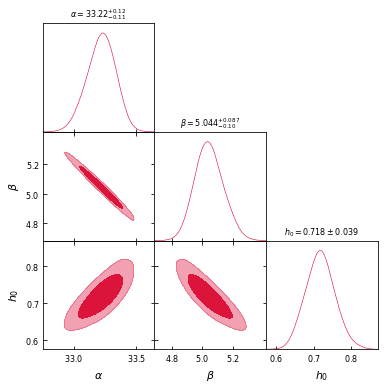

In [16]:
tag = 'GDplot'
path = dpath+'results/GDplot.pdf'
GDsamples = MCSamples(samples=chain, names=parameters,
                          labels=parameters, name_tag=tag #,
                          # ranges={r"\Omega_m":[0.0, None]}
                          )

g = plots.getSubplotPlotter() #width_inch=4
g.settings.num_plot_contours = 2
g.triangle_plot(GDsamples, filled=True, title_limit=1,
            contour_colors=['crimson']
            # , param_limits={r"\alpha":[32.8, 33.7]
                        # , r"\beta":[4.7, 5.35]
                        # , r"h":[0.6, 0.85]
                        # , r"\Omega_m":[0.0, 0.52]
                        # , r"w_0":[-2.1, -0.2]
                        # }
            )
g.export(path)

Imprimiendo los resultados

In [17]:
t = GDsamples.getTable(limit=1).tableTex()
theta = GDsamples.getMeans()

# Print parameter values
print('parameter values:')
for name, col in zip(parameters, chain.transpose()):
  print('%15s : %.3f +- %.3f' % (name, col.mean(), col.std()))

print(t)

parameter values:
         \alpha : 33.220 +- 0.115
          \beta : 5.044 +- 0.094
            h_0 : 0.718 +- 0.039
\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\alpha         $} & $33.22^{+0.12}_{-0.11}     $\\

{\boldmath$\beta          $} & $5.044^{+0.087}_{-0.10}    $\\

{\boldmath$h_0            $} & $0.718\pm 0.039            $\\
\hline
\end{tabular}


**Ejercicio 1:** Con el mismo procedimiento calcualar el conjunto de parametros {alpha, beta, h_0, Om} utilizando un prior de 0.0 < Om < 1.0

In [18]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    alpha, beta, h0, Om = theta

    Or = 4.153e-5 * h0**(-2)
    w0 = -1.0

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

In [19]:
def lnprior(theta):
    alpha, beta, h0, Om = theta
    if (0.0 <= beta <= 10.0 and 20.0 <= alpha <= 40.0 and 0.5 <= h0 <= 1.0 and 0.0 <= Om <= 1.0):
        return 0.0
    return -np.inf

In [20]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

In [28]:
# First guess
parameters = [r"\alpha", r"\beta", r"h_0", r"\Omega_m"]
ialpha = 32.0
ibeta = 5.0
ih0 = 0.75
iOm = 0.3

In [25]:
# MCMC
nsteps = 1000
ndim, nwalkers = 4, 10
start = [[ialpha, ibeta, ih0, iOm] + 1e-5*np.random.randn(ndim)
       for i in range(nwalkers)]

with Pool() as pool:
  sampler = zeus.EnsembleSampler(nwalkers, ndim, lnpost, 
                                 args=(vx, vy, vz, vxErr, vyErr, vzErr), pool=pool)
  sampler.run_mcmc(start, nsteps)

sampler.summary

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 4
Number of Walkers: 10
Number of Tuning Generations: 33
Scale Factor: 0.161584
Mean Integrated Autocorrelation Time: 9.29
Effective Sample Size: 1076.31
Number of Log Probability Evaluations: 93111
Effective Samples per Log Probability Evaluation: 0.011559


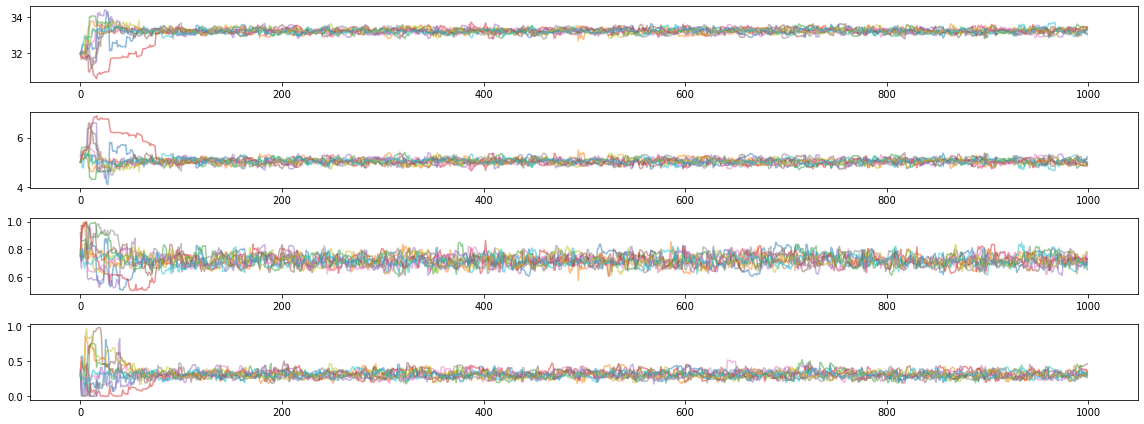

In [26]:
path = dpath+'results/chain_test_Om.pdf'
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
plt.tight_layout()
plt.savefig(path)
plt.show()

In [27]:
# flatten the chains, thin them by a factor of 1, and remove the burn-in (first 25% of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//4, thin=1)

Removed no burn in


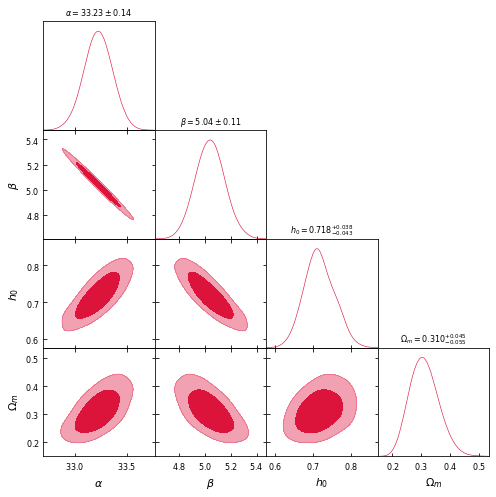

In [29]:
tag = 'GDplot'
path = dpath+'results/GDplotOm.pdf'
GDsamples = MCSamples(samples=chain, names=parameters,
                          labels=parameters, name_tag=tag #,
                          # ranges={r"\Omega_m":[0.0, None]}
                          )

g = plots.getSubplotPlotter() #width_inch=4
g.settings.num_plot_contours = 2
g.triangle_plot(GDsamples, filled=True, title_limit=1,
            contour_colors=['crimson']
            # , param_limits={r"\alpha":[32.8, 33.7]
                        # , r"\beta":[4.7, 5.35]
                        # , r"h":[0.6, 0.85]
                        # , r"\Omega_m":[0.0, 0.52]
                        # , r"w_0":[-2.1, -0.2]
                        # }
            )
g.export(path)